In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
!pip install category_encoders

import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
# Turn off the warning altogether
pd.set_option('mode.chained_assignment',None)

In [22]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


Visualize the model's training progress

In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

# The Auto MPG dataset
The dataset is available from the UCI [Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data).

## Get the data
First download and import the dataset using pandas:

In [24]:
import numpy as np

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
names = ["mpg", "cylinders", "displacement", "horsepower", "weight","acceleration", "model year", "origin", "car name"]
widths = [7, 4, 10, 10, 11, 7, 4, 4, 30]

# Get the data
X_full = pd.read_fwf(url, names=names, widths=widths, na_values=['?'])
X = X_full.copy()
X.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,"""ford mustang gl"""
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,"""vw pickup"""
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,"""dodge rampage"""
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,"""ford ranger"""
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,"""chevy s-10"""


## Feature Engineering

Create a new feature named "company" basing on "car name"

In [25]:
# A dictionary of companies getting from a feature "car name"
brands_dict = {
    "amc": "AMC",
    "audi": "Audi",
    "bmw": "Bmw",
    "buick": "Buick",
    "cadillac": "Cadillac",
    "capri": "Capri",
    "chevroelt": "Chevrolet",
    "chevrolet": "Chevrolet",
    "chevy": "Chevrolet",
    "chrysler": "Chrysler",
    "datsun": "Datsun",
    "dodge": "Dodge",
    "fiat": "Fiat",
    "ford": "Ford",
    "hi": "IH",
    "honda": "Honda",
    "maxda": "Mazda",
    "mazda": "Mazda",
    "mercedes": "Mercedes-Benz",
    "mercedes-benz": "Mercedes-Benz",
    "mercury": "Mercury",
    "nissan": "Nissan",
    "oldsmobile": "Oldsmobile",
    "opel": "Opel",
    "peugeot": "Peugeot",
    "plymouth": "Plymouth",
    "pontiac": "Pontiac",
    "renault": "Renault",
    "saab": "Saab",
    "subaru": "Subaru",
    "toyota": "Toyota",
    "toyouta": "Toyota",
    "triumph": "Triumph",
    "vokswagen": "Volkswagen",
    "volkswagen": "Volkswagen",
    "volvo": "Volvo",
    "vw": "Volkswagen"
}


# Create a new feature named Company
X["company"] = [brands_dict[X["car name"][i].replace('"', '').split()[0]] for i in range(len(X["car name"]))]
X.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,company
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,"""ford mustang gl""",Ford
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,"""vw pickup""",Volkswagen
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,"""dodge rampage""",Dodge
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,"""ford ranger""",Ford
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,"""chevy s-10""",Chevrolet


## Data Correlation

Correlation map to see how features are correlated with each other and with "mpg".

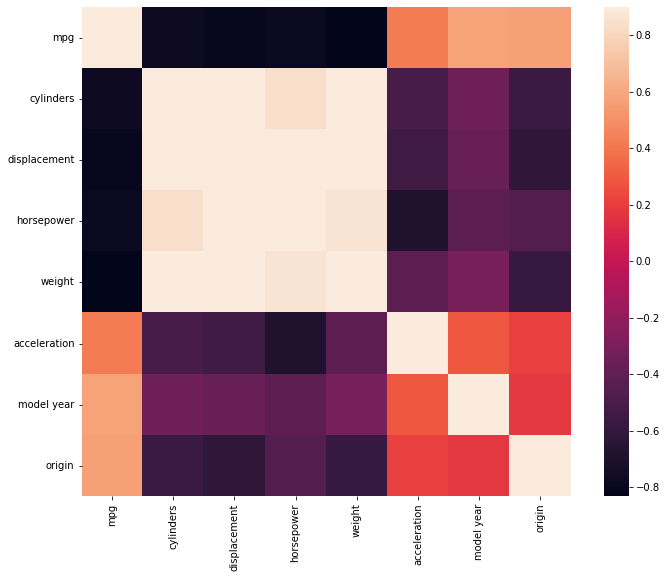

In [26]:
corr_matrix = X_full.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True)

Look at some correlation values in a list format.

In [27]:
print(corr_matrix["mpg"].sort_values(ascending=False)[:5], '\n')
print(corr_matrix["mpg"].sort_values(ascending=False)[-5:])

mpg             1.000000
model year      0.579267
origin          0.563450
acceleration    0.420289
cylinders      -0.775396
Name: mpg, dtype: float64 

acceleration    0.420289
cylinders      -0.775396
horsepower     -0.778427
displacement   -0.804203
weight         -0.831741
Name: mpg, dtype: float64


As we can see, the columns "displacement" and "weight" are strongly negatively correlated.

We can guess if we predict the "mpg" value from given columns, the "displacement" and "weight" will predict better than others.

# Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [28]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=["mpg"], inplace=True)

y = X["mpg"]
X.drop(["mpg"], axis=1, inplace=True)

## Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Clean tha data

Identify columns with missing values

In [30]:
print(X_train.isna().sum())
print(X_valid.isna().sum())

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
company         0
dtype: int64
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
company         0
dtype: int64


The column "horsepower" contains missing value.

Use SimpleImputer to replace missing values with the mean value and create a new column name "hp".

In [31]:
from sklearn.impute import SimpleImputer

# Imputation
hp_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputed_hp_train = hp_imputer.fit(X_train[["horsepower"]])
imputed_hp_valid = hp_imputer.fit(X_valid[["horsepower"]])

# Put them back to X_train and X_valid dataframe
X_train["hp"] = imputed_hp_train.transform(X_train[["horsepower"]]).ravel()
X_valid["hp"] = imputed_hp_valid.transform(X_valid[["horsepower"]]).ravel()

In [32]:
print(X_train.isna().sum())
print(X_valid.isna().sum())

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
company         0
hp              0
dtype: int64
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
company         0
hp              0
dtype: int64


The "origin" column is categorical, not numeric. 

So the next step is to one-hot encode the values in the column with OneHotEncoder class from scikit-learn.

In [33]:
X_train.tail()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,company,hp
393,4,140.0,86.0,2790.0,15.6,82,1,"""ford mustang gl""",Ford,86.0
255,4,140.0,88.0,2720.0,15.4,78,1,"""ford fairmont (man)""",Ford,88.0
72,8,304.0,150.0,3892.0,12.5,72,1,"""amc matador (sw)""",AMC,150.0
235,4,97.0,75.0,2265.0,18.2,77,3,"""toyota corolla liftback""",Toyota,75.0
37,6,232.0,100.0,3288.0,15.5,71,1,"""amc matador""",AMC,100.0


In [34]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[["origin"]]))
OH_cols_valid = pd.DataFrame(OH_encoder.fit_transform(X_valid[["origin"]]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Add one-hot encoded columns to numerical features
X_train = pd.concat([X_train, OH_cols_train], axis=1)
X_valid = pd.concat([X_valid, OH_cols_valid], axis=1)

In [35]:
X_train.tail()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,company,hp,0,1,2
393,4,140.0,86.0,2790.0,15.6,82,1,"""ford mustang gl""",Ford,86.0,1.0,0.0,0.0
255,4,140.0,88.0,2720.0,15.4,78,1,"""ford fairmont (man)""",Ford,88.0,1.0,0.0,0.0
72,8,304.0,150.0,3892.0,12.5,72,1,"""amc matador (sw)""",AMC,150.0,1.0,0.0,0.0
235,4,97.0,75.0,2265.0,18.2,77,3,"""toyota corolla liftback""",Toyota,75.0,0.0,0.0,1.0
37,6,232.0,100.0,3288.0,15.5,71,1,"""amc matador""",AMC,100.0,1.0,0.0,0.0


In [36]:
X_valid.tail()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,company,hp,0,1,2
146,4,90.0,75.0,2125.0,14.5,74,1,"""dodge colt""",Dodge,75.0,1.0,0.0,0.0
327,5,121.0,67.0,2950.0,19.9,80,2,"""audi 5000s (diesel)""",Audi,67.0,0.0,1.0,0.0
223,8,318.0,145.0,4140.0,13.7,77,1,"""dodge monaco brougham""",Dodge,145.0,1.0,0.0,0.0
159,8,351.0,148.0,4657.0,13.5,75,1,"""ford ltd""",Ford,148.0,1.0,0.0,0.0
23,4,121.0,113.0,2234.0,12.5,70,2,"""bmw 2002""",Bmw,113.0,0.0,1.0,0.0


The "company" is a categorical variable with high cardinality.

It is not wise to use one-hot encoding since it can create very high dimensionality, instead we will use Target-based Encoding.

In [37]:
from category_encoders import TargetEncoder

encoder = TargetEncoder()
encoded_comp_train = encoder.fit(X_train[["company"]], y_train)
encoded_comp_valid = encoder.fit(X_valid[["company"]], y_valid)

# Put them back to X_train and X_valid dataframe
X_train["company_encode"] = encoded_comp_train.transform(X_train[["company"]])
X_valid["company_encode"] = encoded_comp_valid.transform(X_valid[["company"]])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
X_train.tail()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,company,hp,0,1,2,company_encode
393,4,140.0,86.0,2790.0,15.6,82,1,"""ford mustang gl""",Ford,86.0,1.0,0.0,0.0,17.830802
255,4,140.0,88.0,2720.0,15.4,78,1,"""ford fairmont (man)""",Ford,88.0,1.0,0.0,0.0,17.830802
72,8,304.0,150.0,3892.0,12.5,72,1,"""amc matador (sw)""",AMC,150.0,1.0,0.0,0.0,21.138468
235,4,97.0,75.0,2265.0,18.2,77,3,"""toyota corolla liftback""",Toyota,75.0,0.0,0.0,1.0,32.961914
37,6,232.0,100.0,3288.0,15.5,71,1,"""amc matador""",AMC,100.0,1.0,0.0,0.0,21.138468


In [39]:
X_valid.tail()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,company,hp,0,1,2,company_encode
146,4,90.0,75.0,2125.0,14.5,74,1,"""dodge colt""",Dodge,75.0,1.0,0.0,0.0,26.254544
327,5,121.0,67.0,2950.0,19.9,80,2,"""audi 5000s (diesel)""",Audi,67.0,0.0,1.0,0.0,26.975373
223,8,318.0,145.0,4140.0,13.7,77,1,"""dodge monaco brougham""",Dodge,145.0,1.0,0.0,0.0,26.254544
159,8,351.0,148.0,4657.0,13.5,75,1,"""ford ltd""",Ford,148.0,1.0,0.0,0.0,17.830802
23,4,121.0,113.0,2234.0,12.5,70,2,"""bmw 2002""",Bmw,113.0,0.0,1.0,0.0,23.612504


## Select features we will use to train the model

In [40]:
features = ["cylinders", "displacement", "weight", "acceleration", "model year", "hp", 0, 1, 2, "company_encode"]
X_train[features].tail()

,cylinders,displacement,weight,acceleration,model year,hp,0,1,2,company_encode
393,4,140.0,2790.0,15.6,82,86.0,1.0,0.0,0.0,17.830802
255,4,140.0,2720.0,15.4,78,88.0,1.0,0.0,0.0,17.830802
72,8,304.0,3892.0,12.5,72,150.0,1.0,0.0,0.0,21.138468
235,4,97.0,2265.0,18.2,77,75.0,0.0,0.0,1.0,32.961914
37,6,232.0,3288.0,15.5,71,100.0,1.0,0.0,0.0,21.138468


# Normalization

It is good practice to normalize features that use different scales and ranges.

The ```tf.keras.layers.Normalization``` is a clean and simple way to add feature normalization into your model.

# Linear Regression

## Linear regression with one variable

Begin with a single-variable linear regression to predict "mpg" 
from "cylinders", "displacement", "weight", "acceleration", "model year", "hp", one by one.

In [41]:
%%time
def linear_regression_single(column):
    # Create a numpy array made of the feature with column name 
    feature = np.array(X_train[column])
    # Init the tf.keras.layers.Normalization
    feature_normalizer = layers.Normalization(input_shape=[1,], axis=None)
    # Fit the state of the preprocessing layer to the horsepower data
    feature_normalizer.adapt(feature)
    
    # Build the Keras Sequential model
    model = tf.keras.Sequential([
        feature_normalizer,
        layers.Dense(units=1)
    ])
    
    # Configure the training procedure using the Keras Model.compile method
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error"
    )

    # Execute the training for 100 epochs
    history = model.fit(
        X_train[column], y_train, epochs=100, verbose=0, validation_split=0.2
    )
    print("Finish ", column)

    return model, history

test_results = {}
for f in ["cylinders", "displacement", "weight", "acceleration", "model year", "hp", "company_encode"]:
    feature_model, history = linear_regression_single(f)
    test_results[f+"_model"] = feature_model.evaluate(
        X_valid[f],
        y_valid, verbose=0)

Finish  cylinders
Finish  displacement
Finish  weight
Finish  acceleration
Finish  model year
Finish  hp
Finish  company_encode
CPU times: user 20.7 s, sys: 1.16 s, total: 21.8 s
Wall time: 20.2 s


Back to our first assumption, the "displacement" and "weight" features have a better score than others.

In [42]:
test_results

{'acceleration_model': 5.408997058868408,
 'company_encode_model': 4.265753746032715,
 'cylinders_model': 3.056208372116089,
 'displacement_model': 2.8516335487365723,
 'hp_model': 3.421321392059326,
 'model year_model': 5.621662616729736,
 'weight_model': 2.5719058513641357}

## Linear regression with multiple inputs

In [43]:
%%time
def linear_regression_multi(columns):
    # Create a numpy array made of the feature with column name 
    features = np.array(X_train[columns])
    # Create the tf.keras.layers.Normalization
    features_normalizer = layers.Normalization(axis=-1)
    # Fit the state of the preprocessing layer to the horsepower data
    features_normalizer.adapt(features)
    
    # Build the Keras Sequential model
    model = tf.keras.Sequential([
        features_normalizer,
        layers.Dense(units=1)
    ])
    
    # Configure the training procedure using the Keras Model.compile method
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error"
    )

    # Execute the training for 100 epochs
    history = model.fit(
        X_train[columns], y_train, epochs=100, verbose=0, validation_split=0.2
    )

    return model, history


multi_model, history = linear_regression_multi(features)                                                 
test_results["multi_model"] = multi_model.evaluate(
    X_valid[features],
    y_valid, verbose=0)

CPU times: user 3.31 s, sys: 143 ms, total: 3.46 s
Wall time: 3.2 s


# Regression with a deep neural network (DNN)
These models will contain a few more layers than the linear model:

- The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model).

- Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.

- A linear Dense single-output layer.

In [44]:
%%time
def dnn_regression_multi(columns):
    # Create a numpy array made of the feature with column name 
    features = np.array(X_train[columns])
    # Create the tf.keras.layers.Normalization
    features_normalizer = layers.Normalization(axis=-1)
    # Fit the state of the preprocessing layer to the horsepower data
    features_normalizer.adapt(features)
    
    # Build the Keras Sequential model
    model = tf.keras.Sequential([
        features_normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),        
        layers.Dense(units=1)
    ])
    
    # Configure the training procedure using the Keras Model.compile method
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error"
    )

    # Execute the training for 100 epochs
    history = model.fit(
        X_train[columns], y_train, epochs=100, verbose=0, validation_split=0.2
    )

    return model, history


dnn_model, history = dnn_regression_multi(features)                                                 
test_results["dnn_model"] = dnn_model.evaluate(
    X_valid[features],
    y_valid, verbose=0)

CPU times: user 3.68 s, sys: 212 ms, total: 3.89 s
Wall time: 3.5 s


# Performance

Since all models have been trained, you can review their test set performance.

The "dnn_model" has the highest score which indicates it the best model amongs the stars.

In [45]:
pd.DataFrame(test_results, index=['Mean absolute error [mpg]']).T

,Mean absolute error [mpg]
cylinders_model,3.056208
displacement_model,2.851634
weight_model,2.571906
acceleration_model,5.408997
model year_model,5.621663
hp_model,3.421321
company_encode_model,4.265754
multi_model,2.082803
dnn_model,1.871473


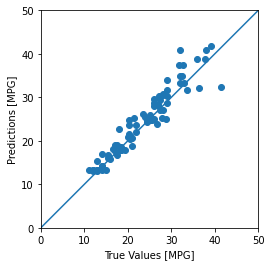

In [46]:
predictions = dnn_model.predict(X_valid[features]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_valid, predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

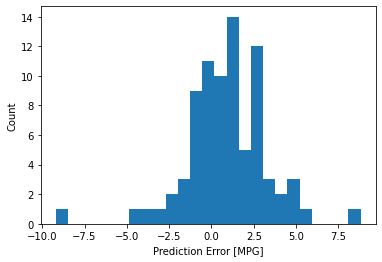

In [47]:
error = predictions - y_valid
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### Save it for later use

In [48]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


### Reload the model

In [49]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    X_train[features], y_train, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [mpg]']).T

,Mean absolute error [mpg]
cylinders_model,3.056208
displacement_model,2.851634
weight_model,2.571906
acceleration_model,5.408997
model year_model,5.621663
hp_model,3.421321
company_encode_model,4.265754
multi_model,2.082803
dnn_model,1.871473
reloaded,1.762385
